In [1]:
#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
import GPy
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(1)

# A brief guide to GP classification with GPy

### James Hensman, November 2014
#### with edits by Alan Saul

Gaussian Process classification is perhaps the most popular case of a GP model where the likelihood is not conjugate to the prior. In the classification case, the likelihood is Bernoulli, and we must perform approximate inference over the values of the function. There are many approaches to making such an approximation: here we'll start with the popular EP method. 

## The generative model
To illustate GP classification, we'll first consider the generative model of the data. In classification, we consider the labels (0 or 1) to be generated by a conditional distribution given the inputs, $\mathbf X$. 

In GP classification, the model is that there is a hidden function, drawn from a GP, which takes continuous values. Those values are then squashed through a probit function,  into the range $[0, 1]$, and can then be used as probabilities. Bernoulli draws are then made (taking the values 0 or 1) conditioned on the squashed values.

First we'll set up a kernel for the GP from which to draw some latent function values (a candidate hidden function for the above generative model), given some arbitrary positions $\mathbf X$ at which we get observations.

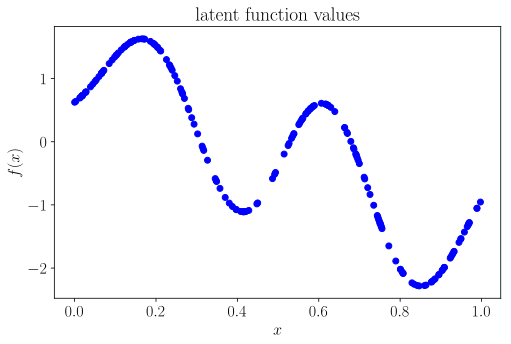

In [2]:
k = GPy.kern.RBF(1, variance=7., lengthscale=0.2)
X = np.random.rand(200,1)

#draw the latent function value
f = np.random.multivariate_normal(np.zeros(200), k.K(X))

plt.plot(X, f, 'bo')
plt.title('latent function values');plt.xlabel('$x$');plt.ylabel('$f(x)$');

Now we'll squash the latent function values through the probit function. We'll set up a GPy likelihood for this, which contains the squashing probit function as well as assorted mechanisms for doing approximate inference.

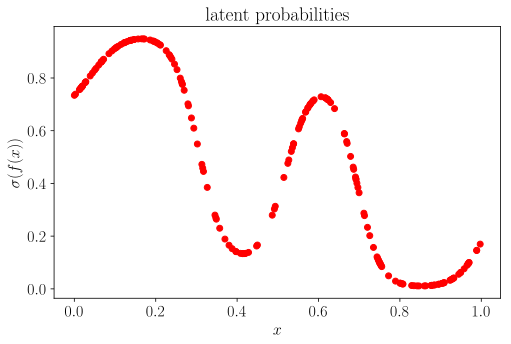

In [3]:
lik = GPy.likelihoods.Bernoulli()
p = lik.gp_link.transf(f) # squash the latent function
plt.plot(X, p, 'ro')
plt.title('latent probabilities');plt.xlabel('$x$');plt.ylabel('$\sigma(f(x))$');

Now binary Bernoulli variables are drawn using the squashed values of our latent function as probabilities:

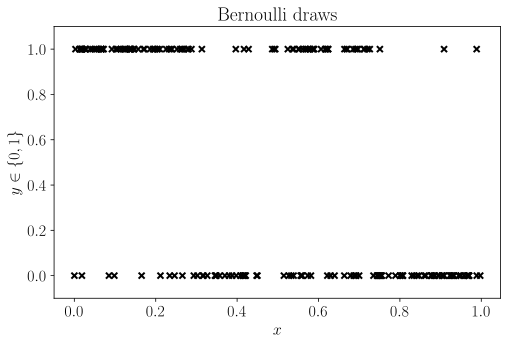

In [4]:
Y = lik.samples(f).reshape(-1,1)
plt.plot(X, Y, 'kx', mew=2);plt.ylim(-0.1, 1.1)
plt.title('Bernoulli draws');plt.xlabel('$x$');plt.ylabel('$y \in \{0,1\}$');

## Inference
We have now generated some data from our proposed model. We'll now attempt to 

In this case we wish to know, given the observed binary variables, can we recover the latent function, the associated probabilities, and the variance and lengthscale of the GP that we believe produced the data?

We'll set up a GPy classifier to do this. first we'll use the most general setup for defining a GP object in GPy, allowing us to select the EP inference method and use our existing likelihood and kernel.

In [5]:
m = GPy.core.GP(X=X,
                Y=Y, 
                kernel=k, 
                inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
                likelihood=lik)
print (m)


Name : gp
Objective : 101.52602911311796
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |    7.0  |      +ve      |        
  rbf.lengthscale  |    0.2  |      +ve      |        


There's a simpler way to build GP classifiers, with some default options (RBF kernel, EP inference) like so:

In [6]:
m = GPy.models.GPClassification(X,Y)

This model is initialized with incorrect lengthscale and variance, but let's check out how it's fared in inferring the latent fuction values:

 /Users/tania/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


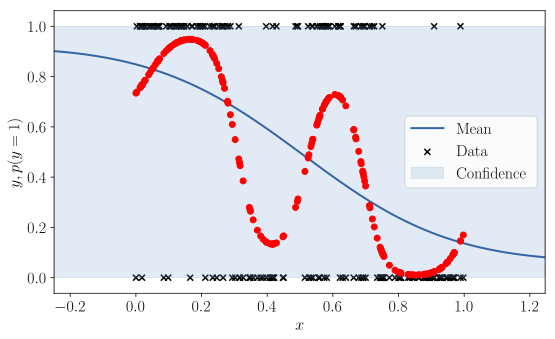

 /Users/tania/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


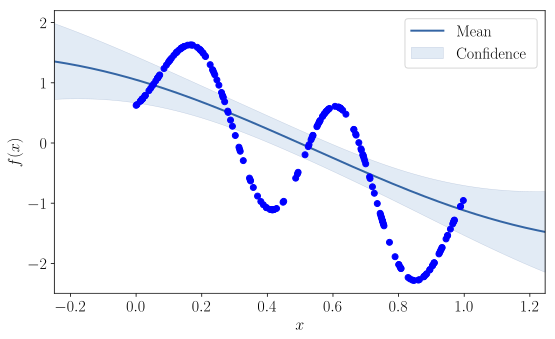

In [7]:
m.plot()
plt.plot(X, p, 'ro')
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$')

m.plot_f()
plt.plot(X, f, 'bo')
plt.ylabel('$f(x)$');plt.xlabel('$x$');

In the above plots, we can see the posterior over the latent probabilities (top) and latent continuous function values (bottom). We've already run EP to obtain the approximate posterior and marginal likelihood. The above plots suggest that the lengthscale of the kernel is incorrect for this problem, so we'll optimize the parameters of the kernel against the approximate marginal likelihood, $p(y|\mathcal{M})$, that represents how probable the data is given our model, $\mathcal{M}$. 

To do this, we interleave runs of EP with optimization of the parameters using gradient descent methods. EP is a method for fitting a Gaussian to the posterior, $p(f|y)$, of the latent (hidden) function, given the data. Whilst the parameters are being optimized, the EP approximation (the parameters of the EP factors) is fixed.  

In [8]:
print (m, '\n')
for i in range(5):
    m.optimize('bfgs', max_iters=100) #first runs EP and then optimizes the kernel parameters
    print ('iteration:', i,)
    print (m)
    print ("")
        


Name : gp_classification
Objective : 114.55764812981656
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  rbf.variance        |    1.0  |      +ve      |        
  rbf.lengthscale     |    1.0  |      +ve      |         

iteration: 0

Name : gp_classification
Objective : 101.13085056184875
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |           value  |  constraints  |  priors
  rbf.variance        |   1.01060758707  |      +ve      |        
  rbf.lengthscale     |  0.142281489653  |      +ve      |        

iteration: 1

Name : gp_classification
Objective : 99.61189900335003
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |           value  |  constraints  |  priors
  rbf.variance        |   1.23624246765  |      +ve      |        
  rbf.lengthscale     

Now our parameters have been optimised to the values that give the largest marginal likelihood, we can plot the results to see how they differ

 /Users/tania/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


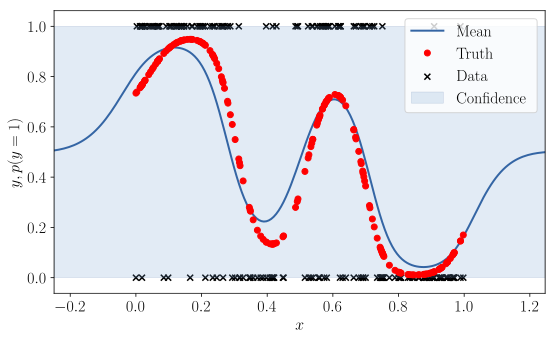

 /Users/tania/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


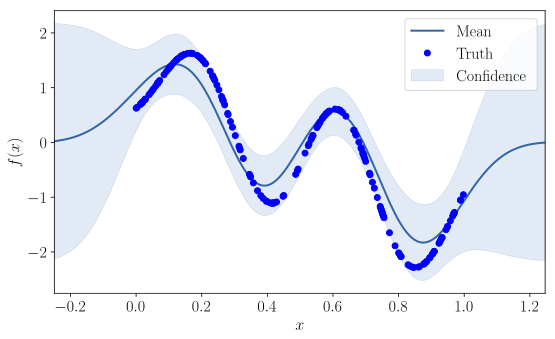

In [9]:
m.plot()
plt.plot(X, p, 'ro', label='Truth')
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$')
plt.legend()
m.plot_f()
plt.plot(X, f, 'bo', label='Truth')
plt.ylabel('$f(x)$');plt.xlabel('$x$')
plt.legend();

The above plots are much more satisfactory: we have managed to infer the correct form of the latent function. We note that it's also possible to run MCMC to obtain Bayesian marginalization of the kernel parameters instead of the (type-II) maximum likelihood approach here. We'll adress this in a forthcoming notebook.

We've seen the generating process for GP classification, and how to set up models in GPy to do classification. We've used EP to infer the latent function, interleaved with optimization of the kernel parameters. There are other latent-function inference methods in GPy, such as the Laplace approximation and the forthcoming variational approximation. These are illustrated in accompanying notebooks.

### Plotting the density more fine-grained

The newest version of GPy allows for densities to be plotted more directly. The outcome of this may surprise you, but it is actually what the density looks like for a Bernoulli likelihood.

 /Users/tania/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


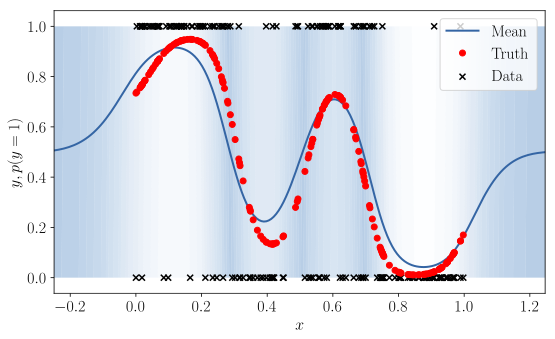

 /Users/tania/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


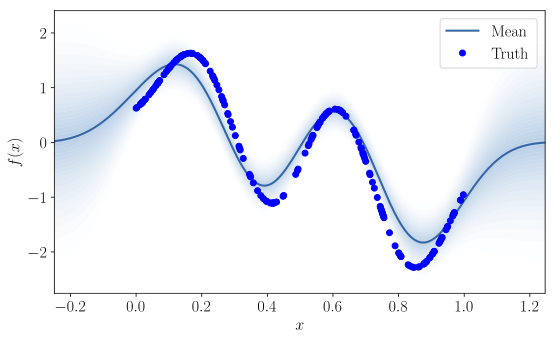

In [10]:
m.plot(plot_density=True)
plt.plot(X, p, 'ro', label='Truth')
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$')
plt.legend()
m.plot_f(plot_density=True)
plt.plot(X, f, 'bo', label='Truth')
plt.ylabel('$f(x)$');plt.xlabel('$x$')
plt.legend();